### Import and checking device

In [1]:
from fastMONAI.vision_all import *
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [2]:
#Making sure the code is run on GPU
torch.cuda.is_available()
device = torch.device("cuda")
print(device)

cuda


In [3]:
#Checking fastMONAI version of access all neccesary functions
import fastMONAI
fastMONAI.__version__

'0.3.0'

### Get data
Loading all datasets from a CSV containing path to FLAIR image and binary lesion mask.
CSV is in the following format:

"path_to_FLAIR_images_folder1","path_to_binary_lesion_mask_folder1"

...

"path_to_FLAIR_images_folderN","path_to_binary_lesion_mask_folderN"

#### Training set

In [4]:
train_df = pd.read_csv('/home/maarhus/Documents/Master/python_code/code/train_flair_binary_mask.csv')

#Printing shape and head to visualize that it is correct
train_df.shape
train_df.head()

#Since the lesion masks are the ground truth, these are set to y
train_y = train_df.iloc[:, -1]
train_labels = train_y.to_numpy()

#### Validation set
* Not necessary for this the code to run as it was not possible to produce probability maps, it is still kept to show how it would look

In [9]:
val_df = pd.read_csv('/home/maarhus/Documents/Master/python_code/code/val_t1_and_binary_mask.csv')
val_df.shape
val_df.head()

#Getting list of path to lesion mask
val_y = val_df.iloc[:, -1]
val_labels = val_y.to_numpy()

#### Test set

In [5]:
test_df = pd.read_csv('/home/maarhus/Documents/Master/python_code/code/test_flair_binary_mask.csv')

#Printing shape and head to visualize that it is correct
test_df.shape
test_df.head()

#Since the lesion masks are the ground truth, these are set to y
test_y = train_df.iloc[:, -1]
test_labels = train_y.to_numpy()

### Look at training data
Checking that everything looks correct with the data. All voxel sizes should be 1, and the orientation should be the same.

In [6]:
#The lesion masks are made into a MedDataset to visualize and use later
med_dataset = MedDataset(img_list=train_labels, dtype=MedMask, max_workers=12)

#Checking that the binaried lesion masks look correct
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1
0,/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TRAIN/1794852047/lesions_binarised.nii,192,256,199,1.0,1.0,1.0,LAS+,9780368,880
1,/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TRAIN/2269394339/lesions_binarised.nii,192,256,189,1.0,1.0,1.0,LAS+,9289468,260
2,/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TRAIN/1833751217/lesions_binarised.nii,192,256,185,1.0,1.0,1.0,LAS+,9092913,207
3,/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TRAIN/1575054632/lesions_binarised.nii,192,256,186,1.0,1.0,1.0,LAS+,9140700,1572
4,/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TRAIN/1342710018/lesions_binarised.nii,192,256,208,1.0,1.0,1.0,LAS+,10221941,1675


### Resample and reorder
Using the resample and reoder values suggested by the meddataset function.
Printing these values show that the images are not to be resampled (Since the resample value is [1.0, 1.0, 1.0]), and not to be reordered (reorder = False)

In [8]:
resample, reorder = med_dataset.suggestion() 
resample, reorder

([1.0, 1.0, 1.0], False)

### Batch size

In [9]:
#Batch size is set to a standard value of 4
bs=4 

### Finding the largest image size
Finding the largest image sizes to set a smaller size when using PadOrCrop

In [10]:
img_size = med_dataset.get_largest_img_size(resample=resample) #Why do we do this?
img_size

[256.0, 256.0, 231.0]

In [11]:
#Setting a smaller size to use for cropping the images
size = [160,160,128]

### Data Augmentation
Three types of augmentation is performed on the images.
* Normalization
* Cropping
* Adding random affine

In [12]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5)] 

### Load data
Data is loaded into a MedDataBlock, and then into a dataloader to get the training data on the correct format before training

In [13]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(valid_pct=0.1, seed=42), 
                      get_x=ColReader('flair_path'),
                      get_y=ColReader('lesion_path'),
                      item_tfms=item_tfms, 
                      reorder=reorder, 
                      resample=resample) 

In [14]:
dls = dblock.dataloaders(train_df, bs=bs) 

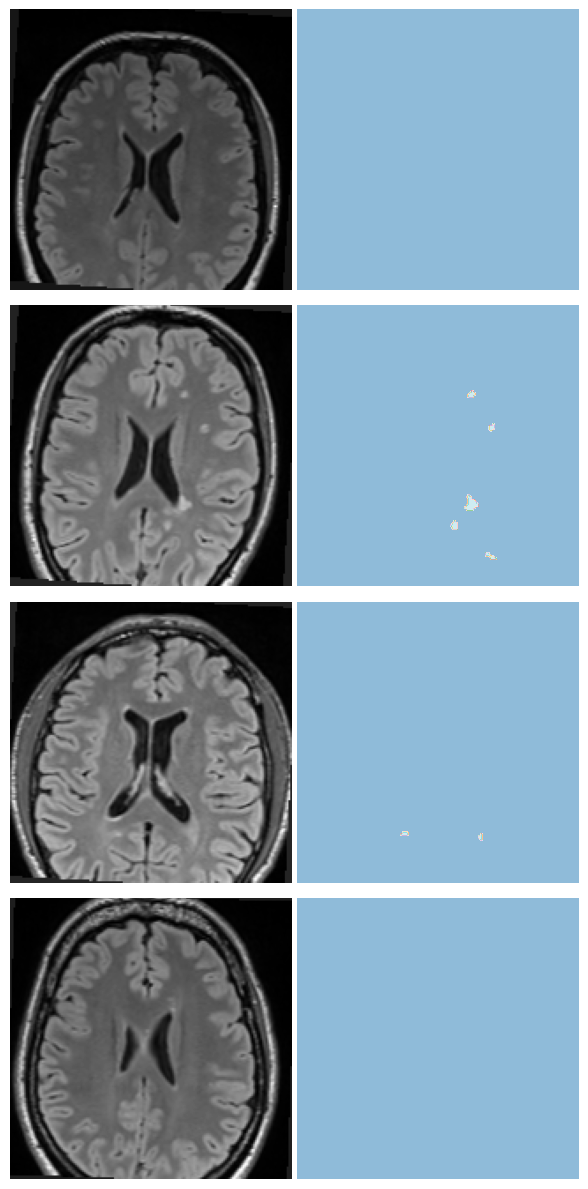

In [16]:
#Visualizing the training data (to the left) and their corresponding mask (to the right)
dls.show_batch(anatomical_plane=2) 

### Create and train a 3D U-Net

The current state-of-the-art CNN models for medical image segmentation tasks are based on encoder-decoder architectures like the U-Net. 
In the following line, aversion of 3D UNet from MONAI is used, in addition to the Dice coefficient (Dice) loss, a commonly used loss function in medical image segmentation tasks: 
\begin{equation*}
\begin{aligned}
loss = 1- \frac{y \cap \hat{y}}{\left | y \right |+\left | \hat{y} \right |}
\end{aligned}
\end{equation*}

In [17]:
#Setting the model to be a 3D U-Net
model = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), num_res_units=2)
model = model.model 

In [18]:
#Loss function is set to be diceloss
loss_func = CustomLoss(loss_func=DiceLoss(sigmoid=True))

In [19]:
#The learning is the instance of the model that is actually trained for segmentation
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=binary_dice_score)

### Learning rate
learn.lr_find() performs a "mock" traning session to visualize how the loss changes with different learning rates.
The valley is defined as a point residing in one of the steepest slopes and is therefore a value suitable to be a learning rate

SuggestedLRs(valley=0.04786301031708717)

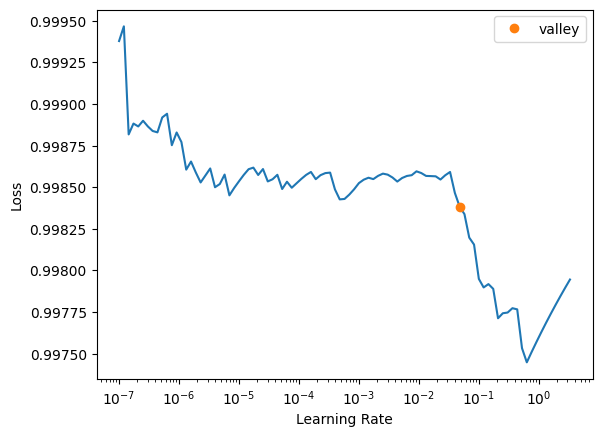

In [34]:
learn.lr_find()

In [35]:
#lr set to 0.048 as suggested by the valley-point
lr = 0.048

### Training the model
The function `fit_flat_cos` is used for traning as this fits well with the Ranger21 optimizer:

https://walkwithfastai.com/Segmentation

* Training took aproximately 2-3 hours

In [36]:
#Set to train for 400 epochs
learn.fit_flat_cos(400 ,lr) 

epoch,train_loss,valid_loss,binary_dice_score,time
0,0.998509,0.997833,0.003363,00:26
1,0.997493,0.996400,0.005108,00:25
2,0.996574,0.995449,0.005174,00:26
3,0.995643,0.993999,0.007796,00:26
4,0.994500,0.993108,0.007685,00:26
5,0.990443,0.963717,0.075450,00:26
6,0.977717,0.990993,0.000367,00:26
7,0.949973,0.811493,0.268078,00:26
8,0.900917,0.691190,0.340692,00:25
9,0.897272,0.988194,0.012350,00:25


/home/maarhus/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <function compute_meandice at 0x7f2ed4353940>: Function `compute_meandice` has been deprecated since version 1.0.0. use `compute_dice` instead.
  warn_deprecated(obj, msg, warning_category)


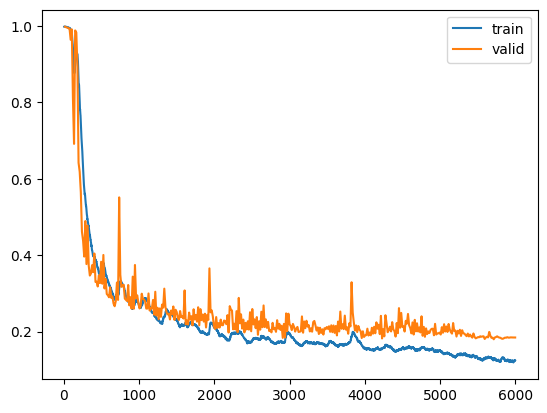

In [37]:
#Plotting training and validation loss
learn.recorder.plot_loss()

### Saving the trained model

In [38]:
learn.save('flair-model')

Path('models/flair-model.pth')

### Model evaluation


In [20]:
#Loading saved model from above
learn.load('flair-model');

In [21]:
#Test dataset is loaded into a dataloader
test_dl = learn.dls.test_dl(test_df,with_labels=True)

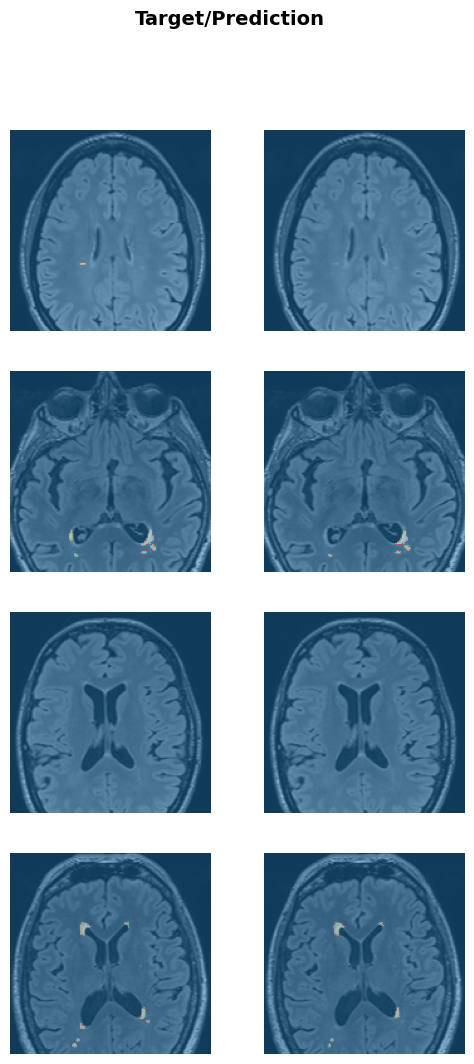

In [24]:
#Looking at some segmentations perforned on the test set
#True lesion masks are shown to the left, predicted masks to the right
learn.show_results(anatomical_plane=2, dl=test_dl)

### Inference
Performs inference on FLAIR images in the test set to get NIfTI segmentations

In [1]:
#Adding the name of the folder in the test set to a list
all_files_list = []
for path, dirs, files in os.walk("/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TEST"):
    if len(dirs) == 0:
        all_files_list.append(os.path.basename(path))


In [31]:
#Iterating through all subjects in the test set and perform inference on the FLAIR images to obtain segmentations
for folder in all_files_list:
    test_path = f'/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TEST/{folder}/FLAIR.nii'
    out = inference(learn, fn=test_path, reorder=reorder, resample=resample, save_path=f'/home/maarhus/Documents/Master/fastMONAI_data/MS_DATA_TEST/{folder}')
